# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
from __future__ import print_function
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt



%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
regularization_strengths = [1e1, 1e2, 1e3, 1e-1, 1e-2, 1e-3, 5e-1, 7e-3, 2e-2, 5e-2, 5e-3, 1e-4]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
lr_rs = [ (lr,rs) for lr in learning_rates for rs in regularization_strengths ]

for lr, rs in lr_rs:
    # Create a new SVM instance
    svm = LinearSVM()
    # Train the model with current parameters
    train_loss = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=False)
    # Predict values for training set
    y_train_pred = svm.predict(X_train_feats)
    # Calculate accuracy
    train_accuracy = np.mean(y_train_pred == y_train)
    # Predict values for validation set
    y_val_pred = svm.predict(X_val_feats)
    # Calculate accuracy
    val_accuracy = np.mean(y_val_pred == y_val)
    # Print results
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, rs, train_accuracy, val_accuracy))
    # Save results
    results[(lr,rs)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_svm = svm 
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
#for lr, reg in sorted(results):
 #   train_accuracy, val_accuracy = results[(lr, reg)]
 #   print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
  #              lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-01 reg 1.000000e+01 train accuracy: 0.019265 val accuracy: 0.022000


/home/serg/workspace/assignment1/cs231n/classifiers/linear_svm.py:81: RuntimeWarning: overflow encountered in double_scalars
  loss = margin.sum() / num_train + reg * np.sum(W * W)
/home/serg/anaconda3/envs/cs231n/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/serg/workspace/assignment1/cs231n/classifiers/linear_svm.py:81: RuntimeWarning: overflow encountered in multiply
  loss = margin.sum() / num_train + reg * np.sum(W * W)
/home/serg/anaconda3/envs/cs231n/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/serg/workspace/assignment1/cs231n/classifiers/linear_svm.py:101: RuntimeWarning: overflow encountered in multiply
  dW = dW + reg * 2 * W
/home/serg/workspace/assignment1/cs231n/classifiers/linear_svm.py:79: RuntimeWarning: overflow encounter

lr 1.000000e-01 reg 1.000000e+02 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-01 reg 1.000000e+03 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-01 reg 1.000000e-01 train accuracy: 0.460347 val accuracy: 0.456000
lr 1.000000e-01 reg 1.000000e-02 train accuracy: 0.485327 val accuracy: 0.480000
lr 1.000000e-01 reg 1.000000e-03 train accuracy: 0.482735 val accuracy: 0.470000
lr 1.000000e-01 reg 5.000000e-01 train accuracy: 0.426449 val accuracy: 0.435000
lr 1.000000e-01 reg 7.000000e-03 train accuracy: 0.481204 val accuracy: 0.488000
lr 1.000000e-01 reg 2.000000e-02 train accuracy: 0.471510 val accuracy: 0.483000
lr 1.000000e-01 reg 5.000000e-02 train accuracy: 0.471796 val accuracy: 0.468000
lr 1.000000e-01 reg 5.000000e-03 train accuracy: 0.473592 val accuracy: 0.472000
lr 1.000000e-01 reg 1.000000e-04 train accuracy: 0.479673 val accuracy: 0.458000
lr 1.000000e-02 reg 1.000000e+01 train accuracy: 0.410918 val accuracy: 0.392000
lr 1.000000e-02 reg 1.000000

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.492


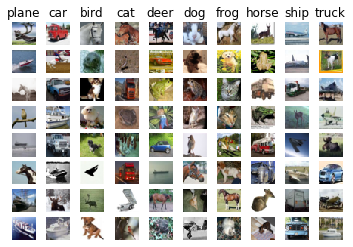

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [11]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    lr = 10**np.random.uniform(lr_min,lr_max)
    reg = 10**np.random.uniform(reg_min,reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden

# Use of random search for hyperparameter search
for i in range(30):
    lr, reg, hd = generate_random_hyperparams(-1, 1, -7, -4, 10, 500)
    # Create a two-layer network
    net = TwoLayerNet(input_dim, hd, num_classes)
    
    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=3000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)

    # Predict on the training set
    train_accuracy = (net.predict(X_train_feats) == y_train).mean()
    
    # Predict on the validation set
    val_accuracy = (net.predict(X_val_feats) == y_val).mean()
    
    # Save best values
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_net = net
    
    # Print results
    print('lr %e reg %e hid %d  train accuracy: %f val accuracy: %f' % (
                lr, reg, hd, train_accuracy, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 2.681143e-01 reg 6.658285e-05 hid 145  train accuracy: 0.672551 val accuracy: 0.575000
lr 1.977963e-01 reg 6.279782e-07 hid 187  train accuracy: 0.653939 val accuracy: 0.587000


/home/serg/workspace/assignment1/cs231n/classifiers/neural_net.py:101: RuntimeWarning: divide by zero encountered in log
  grads = {}
/home/serg/workspace/assignment1/cs231n/classifiers/neural_net.py:97: RuntimeWarning: overflow encountered in subtract
  #                              END OF YOUR CODE                             #
/home/serg/workspace/assignment1/cs231n/classifiers/neural_net.py:97: RuntimeWarning: invalid value encountered in subtract
  #                              END OF YOUR CODE                             #
/home/serg/workspace/assignment1/cs231n/classifiers/neural_net.py:103: RuntimeWarning: overflow encountered in multiply
  # TODO: Compute the backward pass, computing the derivatives of the weights #
/home/serg/workspace/assignment1/cs231n/classifiers/neural_net.py:124: RuntimeWarning: invalid value encountered in greater
  X[i] has label c, where 0 <= c < C.


lr 9.803754e+00 reg 1.672030e-05 hid 106  train accuracy: 0.100265 val accuracy: 0.087000
lr 3.141537e-01 reg 2.708837e-07 hid 140  train accuracy: 0.678735 val accuracy: 0.589000
lr 1.738459e-01 reg 2.972155e-06 hid 391  train accuracy: 0.652939 val accuracy: 0.592000
lr 1.929664e-01 reg 3.035195e-06 hid 492  train accuracy: 0.669184 val accuracy: 0.598000
lr 2.882064e-01 reg 7.626973e-06 hid 41  train accuracy: 0.605918 val accuracy: 0.552000
lr 8.533692e-01 reg 7.856678e-06 hid 336  train accuracy: 0.793408 val accuracy: 0.573000
lr 3.316985e+00 reg 5.095070e-05 hid 442  train accuracy: 0.790388 val accuracy: 0.529000
lr 3.140510e-01 reg 1.728565e-07 hid 50  train accuracy: 0.620265 val accuracy: 0.560000
lr 8.062432e+00 reg 1.935236e-07 hid 326  train accuracy: 0.100265 val accuracy: 0.087000
lr 9.729856e+00 reg 8.317337e-06 hid 400  train accuracy: 0.100265 val accuracy: 0.087000
lr 8.026338e+00 reg 1.863625e-07 hid 361  train accuracy: 0.100265 val accuracy: 0.087000
lr 6.083380e

/home/serg/workspace/assignment1/cs231n/classifiers/neural_net.py:103: RuntimeWarning: overflow encountered in double_scalars
  # TODO: Compute the backward pass, computing the derivatives of the weights #


lr 4.939282e+00 reg 1.828597e-06 hid 327  train accuracy: 0.100265 val accuracy: 0.087000
lr 7.286104e+00 reg 1.515416e-07 hid 111  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.172548e-01 reg 5.294106e-07 hid 424  train accuracy: 0.602878 val accuracy: 0.559000
lr 9.699250e+00 reg 4.628244e-07 hid 415  train accuracy: 0.100265 val accuracy: 0.087000
lr 4.613218e+00 reg 4.760117e-05 hid 323  train accuracy: 0.118959 val accuracy: 0.105000
lr 1.020453e-01 reg 1.734644e-06 hid 417  train accuracy: 0.589714 val accuracy: 0.563000
lr 3.417664e+00 reg 1.753686e-06 hid 268  train accuracy: 0.719918 val accuracy: 0.514000
best validation accuracy achieved: 0.607000


In [12]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.56
